## Leakage Simulation and Detection

### Initialize EPANET Python Toolkit (EPyT)

You should always begin with this command to import the toolkit.

[EPyT](https://github.com/OpenWaterAnalytics/EPyT) is available on [PyPI](https://pypi.org/project/epyt/) and can be installed via `pip install epyt`. To upgrade to the latest version if it's already installed, use `pip install --upgrade epyt`.

In [ ]:
%pip install epyt

In [7]:
from epyt import epanet
import tempfile
import requests
import os

<img src="icons/large_leakage.png" alt="Large Leakage" style="display: inline-block; width: 50%; height: 50%;">
<img src="icons/fire-fighting.png" alt="Fire-Fighting" style="display: inline-block; width: 50%; height: 50%;">

### How pressure changes during large leakages and fire-fighting

When flow is increased within the network, e.g., due to fire-fighting, the pressure changes near that location. Investigate this change, at `node '32'.

In [16]:
def download_file(url, file_path):
    """
    Downloads a file from the given URL and saves it to the specified file path.

    Parameters:
    url (str): The URL to download the file from.
    file_path (str): The path where the downloaded file should be saved.

    Returns:
    str: A message indicating the result of the download.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        with open(file_path, 'wb') as file:
            file.write(response.content)
        return f"File downloaded and saved as {file_path}"
    except requests.exceptions.HTTPError as err:
        return f"HTTP error occurred: {err}"
    except Exception as err:
        return f"An error occurred: {err}"

# Example usage:
url = "https://raw.githubusercontent.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/main/data/Net1.inp?token=GHSAT0AAAAAACTQ7OWEPYPUYKQNMS6UFILGZUBNIXA"
tmpdirpath = tempfile.gettempdir()
inpname = os.path.join(tmpdirpath, "Net1.inp")
result = download_file(url, inpname)
print(result)

File downloaded and saved as C:\Users\mkiri\AppData\Local\Temp\Net1.inp


In [13]:
G = epanet(inpname)

EPANET version 20200 loaded (EPyT version v1.1.9 - Last Update: 24/06/2024).
Input File Net1.inp loaded successfully.



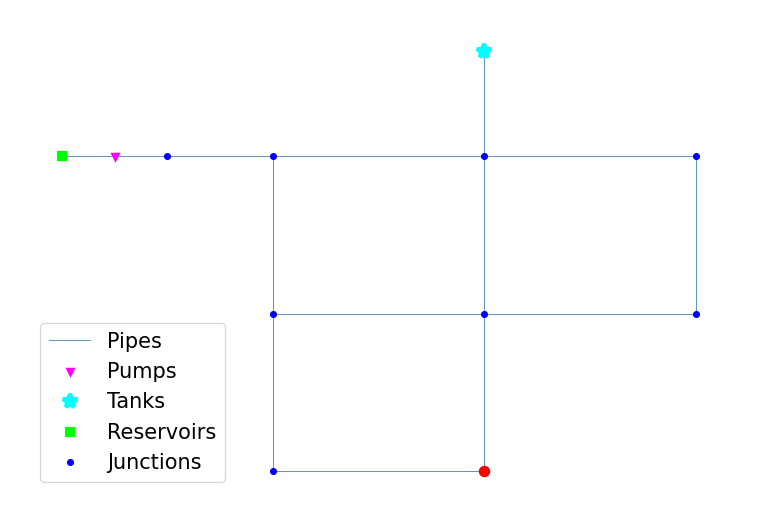

In [14]:
nodeID = '32'
G.plot(highlightnode=nodeID)
G.plot_close()

#### During fire-fighting, the base demand may increase up to x5. Will there be sufficient pressure?

In [15]:
idx = G.getNodeIndex(nodeID)
G.printv(idx)

idx = 9


In [ ]:
bd = G.getNodeBaseDemands(idx)[1]
G.printv(bd)

In [ ]:
# Demand multiplicator
demand_multi = 8 
G.printv(demand_multi)

In [ ]:
import numpy as np

# Create the different threads
d32 = bd * np.arange(1, demand_multi + 1) 
G.printv(d32)

In [ ]:
# Initialize variable
p32min = np.zeros(len(d32))
for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    py_idx = idx - 1
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, py_idx]
    p32min[i] = np.min(p32)

#### Plot demand vs pressure

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)
plt.show()

##### How about those negative pressures?

### Pressure Driven Simulations

##### When the pressure is low, it should approximate zero. This is not the default mode of operation in EPANET. However, it's easy to set it up:

In [ ]:
type = 'PDA'
pmin = 0
preq = 0.1
pexp = 0.5
G.setDemandModel(type, pmin, preq, pexp)

Let's try this again

In [ ]:
# Demand multiplicator
demand_multi = 10 
G.printv(demand_multi)

In [ ]:
# Create the different threads
d32 = bd * np.arange(1, demand_multi + 1) 
G.printv(d32)

In [ ]:
# Initialize variable
p32min = np.zeros(len(d32)) 

for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, idx-1]
    p32min[i] = np.min(p32)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)
plt.show()

In [ ]:
G.unload()

### Leakage Simulations
#### Load network amd set simulation duration and hydraulic step

In [17]:
# Download Hanoi_pat input file
url = "https://raw.githubusercontent.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/main/data/Hanoi_pat.inp?token=GHSAT0AAAAAACTQ7OWFKJA6HQQ2U4R4HHZEZUBNLAQ"
inpname = os.path.join(tmpdirpath, "Hanoi_pat.inp")
result = download_file(url, inpname)
print(result)

File downloaded and saved as C:\Users\mkiri\AppData\Local\Temp\Hanoi_pat.inp


In [ ]:
d=epanet('data/Hanoi_pat.inp')

d.setTimeSimulationDuration(7*24*60*60)
d.setTimeHydraulicStep(300)

#### Simulate without leak

In [ ]:
sim_leak_free = d.getComputedHydraulicTimeSeries()
print(d.getAllAttributes(sim_leak_free))

##### Get inflow without leak and create measurements by inserting random noise

In [ ]:
res_ind = d.getNodeReservoirIndex()
res_link = [np.where(d.NodesConnectingLinksIndex[:, 0] == idx)[0][0] for idx in res_ind]
Inflow1 = sim_leak_free.Flow[:, res_link] # Inflow
eta = np.random.rand(len(Inflow1),1) * np.mean(Inflow1) * 0.0001
y1 = Inflow1 * (1 + eta) # Measured inflow

#### Simulate leakage

In [ ]:
leak_node = 10
leak_emit = 20  # Random leak emitter coefficient [2 20]
emit = d.getNodeEmitterCoeff()
emit = np.zeros_like(emit)
emit[leak_node-1] = leak_emit  # Set emitter coefficient (leakage) value
d.setNodeEmitterCoeff(emit)
sim_leak = d.getComputedHydraulicTimeSeries()

##### Get inflow with leak and create measurements by inserting random noise

In [ ]:
res_ind = d.getNodeReservoirIndex()
res_link = [np.where(d.NodesConnectingLinksIndex[:, 0] == idx)[0][0] for idx in res_ind]
Inflow2 = sim_leak.Flow[:, res_link]  # inflow
Inflow2[:3*288] = Inflow1[:3*288]  # change leak start time
eta = np.random.rand(len(Inflow2),1) * np.mean(Inflow1) * 0.0001
y2 = Inflow2 * (1 + eta)  # measured inflow

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
plt.plot(y1, color='blue', label='leak free')
plt.grid(True)
plt.plot(y2, color='red', label='with leak')
plt.legend(loc='upper right')
plt.title('Network Inflow')
plt.show()

##### Plot leakage location

In [ ]:
leak_node_id = d.getNodeNameID(leak_node)

# Get node coordinates
coor = d.getNodeCoordinates()
x_nodes = list(coor['x'].values())
y_nodes = list(coor['y'].values())

# Get links connecting nodes
links = d.getNodesConnectingLinksIndex()

# Plot the network manually
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
for link in links:
    x_coords = [coor['x'][link[0]], coor['x'][link[1]]]
    y_coords = [coor['y'][link[0]], coor['y'][link[1]]]
    ax.plot(x_coords, y_coords, color='steelblue', linewidth=0.7)

ax.axis('off')

# Plot nodes
ax.scatter(x_nodes, y_nodes, color='blue', s=10, zorder=5)

# Add plot point for the leak node
x_leak = coor['x'][leak_node]
y_leak = coor['y'][leak_node]

# Plot the leak node with a higher zorder
ax.plot(x_leak, y_leak, 'o', color='r', markersize=12, zorder=10)
ax.text(x_leak + 60, y_leak, leak_node_id, color='black', fontweight='bold', fontsize=11, zorder=10)

# Set the title and show the plot
ax.set_title('Leakage location', fontweight='bold')
plt.show()


### Leakage Detection
#### Minimum Night Flow Analysis

<img src="icons/leakage_detection.png" alt="Leakage Detection" style="width: 60%; height: 60%;">

- Basic idea is that each night the uncertainty is low
- Demand is low
- Pressure is high
- Easier to detect leakages

In [ ]:
# compute the minimum flow for each day
Y = np.reshape(y2[1:], (288, 7))
print('Y = ', Y.shape)
d.printv(Y)

In [ ]:
MF = np.min(Y, axis=0)
d.printv(MF)

In [ ]:
# Calculate change indices based on threshold
threshold = 3
changeIndices = np.abs(np.diff(MF)) > threshold  # Find where the absolute difference between consecutive elements is greater than the threshold
changeIndices = np.insert(changeIndices, 0, False)  # Add False at the beginning to align with MF length

# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 3))

# Plot the original data
ax.plot(MF, color='blue', label='Input data')

# Plot the segment mean (in this case, it's the same as the original data)
ax.plot(MF, color='grey', label='Segment mean')

# Find the indices where changes occur
indices = np.where(changeIndices)[0]
x = np.repeat(indices, 3)  # Repeat each index 3 times to align with y3 for plotting vertical lines

# Get the current y-axis limits
ymin, ymax = ax.get_ylim()
ylim_nan_column = np.array([ymin, ymax, np.nan])  # Array to create vertical lines that span the y-axis

# Count the number of change points
nnz_changeIndices = np.count_nonzero(changeIndices)
print("Number of change points:", nnz_changeIndices)

# Create y-coordinates for change points using tile and flatten
y3 = np.tile(ylim_nan_column, (nnz_changeIndices, 1)).flatten()

# Plot the change points as green vertical dashed lines
ax.plot(x, y3, color='green', linestyle='--', label='Change points')

# Set the title to show the number of change points
ax.set_title(f'Number of change points: {np.count_nonzero(changeIndices)}')

# Add a legend in the upper right corner
ax.legend(loc='upper right')

# Display the plot
plt.show()

#### Detecting changes
- Change detection algorithms
- Limit checking, change in mean
- Cumulative Sum (CUSUM)

##### Limit checking, the most simple detection algorithm

In [ ]:
threshold = 30
d.printv(threshold)

In [ ]:
alert = MF-MF[0] > threshold
d.printv(alert)

In [ ]:
fig = plt.figure()
plt.plot(alert, 'r-')
fig.set_figwidth(8)
plt.show()

##### A different approach would be to take a window of minimum (night) flows, and compare them with the new minimum flow. If it exceeds a precalculated distance, the issue an alert.